# Importando os dados

In [119]:
import pandas as pd

In [120]:
dataset = pd.read_csv("insurance.csv")

In [121]:
dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Configurações

Primeiro, vamos garantir que este notebook funcione bem em python 2 e 3, importar alguns módulos comuns, garantir que o MatplotLib plote figuras em linha.

In [122]:
# para deixar todas as saídas com os mesmos valores obtidos na live.
import numpy as np
np.random.seed(42) # Instancia uma semente aleatória, que é útil quando você deseja garantir que os números aleatórios gerados sejam os mesmos em diferentes execuções do código, o que é crucial para reproduzibilidade em experimentos ou análises em um time.
import os

# Para plots bonitinhos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Conhecendo os dados 🤓

In [123]:
dataset.shape

(1338, 7)

In [124]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   idade     1338 non-null   int64  
 1   gênero    1338 non-null   object 
 2   imc       1338 non-null   float64
 3   filhos    1338 non-null   int64  
 4   fumante   1338 non-null   object 
 5   região    1338 non-null   object 
 6   encargos  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Não temos linhas com valores nulos nas respectivas colunas. Vamos analisar se existe alguma linha duplicada.

In [ ]:
dataset.duplicated().sum()

In [ ]:
duplicados = dataset[dataset.duplicated()]

# Exibir os registros duplicados
print(duplicados)

### Vamos excluir a(s) linha(s) duplicadas

In [ ]:
#dataset = dataset.drop_duplicates()
#dataset.duplicated().sum()

Agora vamos analisar os dados do tipo numérico com a função describe():

In [125]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
idade,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
imc,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
filhos,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
encargos,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


Analisando algumas distribuições com histogramas:

array([[<Axes: title={'center': 'idade'}>,
        <Axes: title={'center': 'imc'}>],
       [<Axes: title={'center': 'filhos'}>,
        <Axes: title={'center': 'encargos'}>]], dtype=object)

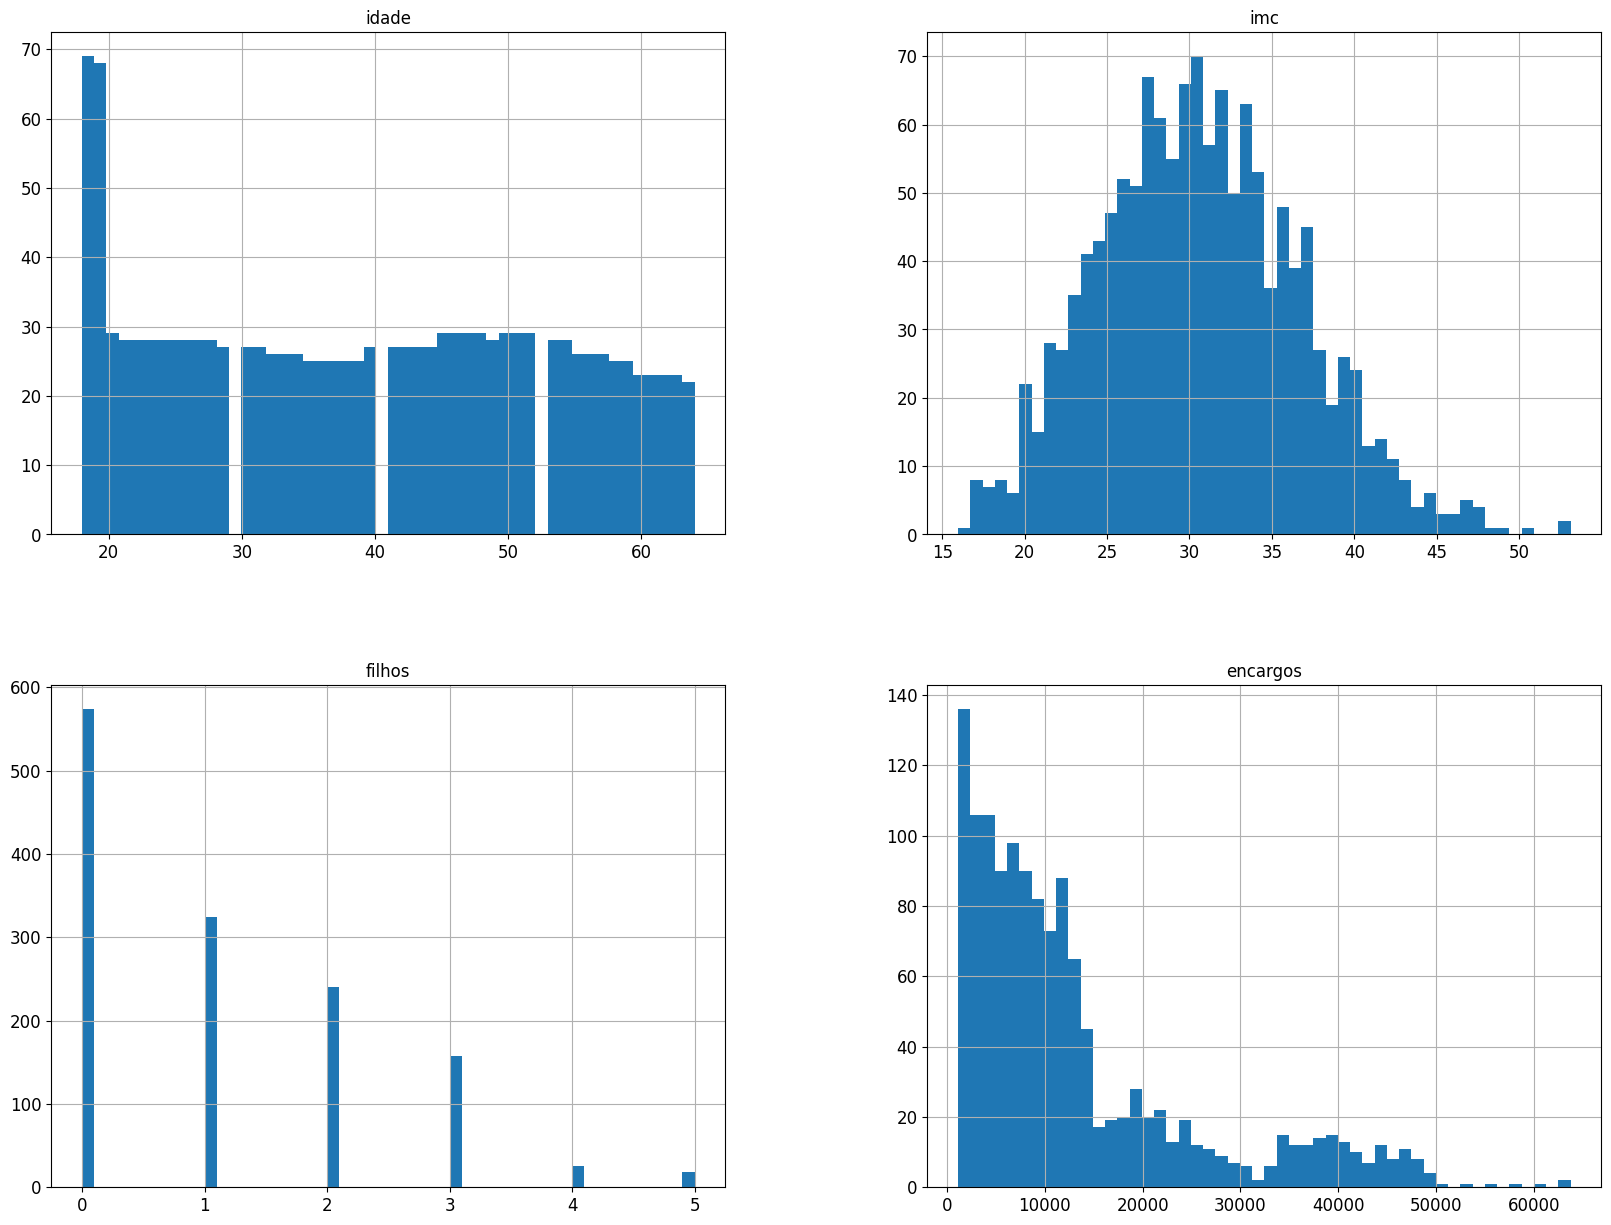

In [126]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.hist(bins=50, figsize=(20,15))

## Criando categorias de IMC (Índice de massa corporal) 🤑

<Axes: >

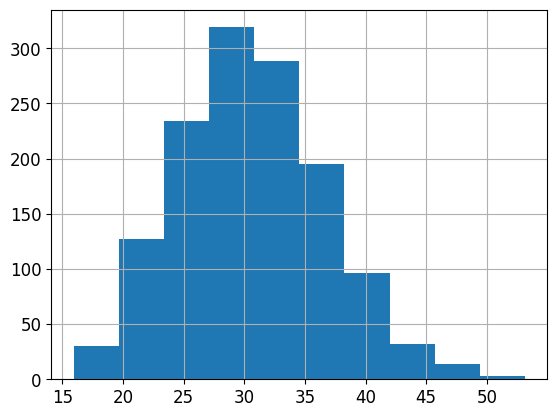

In [127]:
dataset["imc"].hist()

In [128]:
#cut do Pandas, que é comumente usada para dividir um conjunto de dados em intervalos discretos chamados de "bins" (intervalos ou faixas)
dataset["faixas_imc"] = pd.cut(dataset["imc"],
                               bins=[0, 18.5, 24.9, 29.9, 34.9, 39.9, np.inf],
                               labels=[1, 2, 3, 4, 5, 6])

dataset["faixas_imc"].value_counts()

faixas_imc
4    397
3    380
5    226
2    221
6     93
1     21
Name: count, dtype: int64

<Axes: >

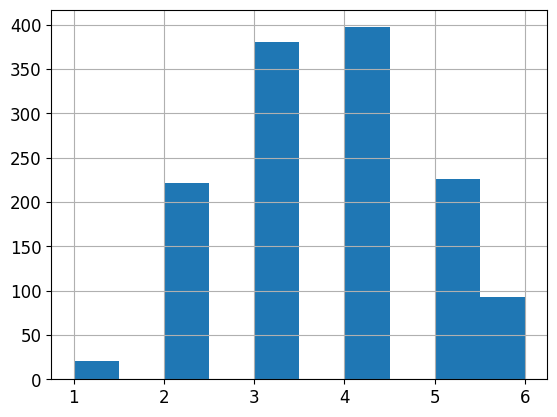

In [129]:
dataset["faixas_imc"].hist()

Resumindo, esse código está transformando valores contínuos de índice de massa corporal em categorias discretas, dividindo-os em intervalos específicos, garantindo que o número de categorias seja limitado e, finalmente, atribuindo rótulos numéricos a essas categorias.

In [130]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

dataset['genero_tipo'] = label_encoder.fit_transform(dataset['gênero'])
dataset['fumante_tipo'] = label_encoder.fit_transform(dataset['fumante'])
dataset['regiao_tipo'] = label_encoder.fit_transform(dataset['região'])

dataset.head()

,idade,gênero,imc,filhos,fumante,região,encargos,faixas_imc,genero_tipo,fumante_tipo,regiao_tipo
0,19,female,27.900,0,yes,southwest,16884.92400,3,0,1,3
1,18,male,33.770,1,no,southeast,1725.55230,4,1,0,2
2,28,male,33.000,3,no,southeast,4449.46200,4,1,0,2
3,33,male,22.705,0,no,northwest,21984.47061,2,1,0,1
4,32,male,28.880,0,no,northwest,3866.85520,3,1,0,1


In [131]:
dataset_tratado = dataset.drop(columns = [ "imc", "fumante", "região", "gênero"]).copy()

dataset_tratado.head()

,idade,filhos,encargos,faixas_imc,genero_tipo,fumante_tipo,regiao_tipo
0,19,0,16884.92400,3,0,1,3
1,18,1,1725.55230,4,1,0,2
2,28,3,4449.46200,4,1,0,2
3,33,0,21984.47061,2,1,0,1
4,32,0,3866.85520,3,1,0,1


Boa! Agora com as categorias criadas, vamos realizar a amostragem estratificada com base no índice de massa corporal.

In [132]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset_tratado, dataset_tratado["faixas_imc"]):
    strat_train_set = dataset_tratado.loc[train_index]
    strat_test_set = dataset_tratado.loc[test_index]

In [134]:
# Analisando as proporções de teste
strat_test_set["faixas_imc"].value_counts() / len(strat_test_set)

faixas_imc
4    0.298507
3    0.283582
5    0.167910
2    0.164179
6    0.070896
1    0.014925
Name: count, dtype: float64

In [135]:
# Analisando as proporções de treino
strat_train_set["faixas_imc"].value_counts() / len(strat_train_set)

faixas_imc
4    0.296262
3    0.284112
5    0.169159
2    0.165421
6    0.069159
1    0.015888
Name: count, dtype: float64

In [136]:
dataset["faixas_imc"].value_counts() / len(dataset)# Fazer o mesmo para o dataset original

faixas_imc
4    0.296712
3    0.284006
5    0.168909
2    0.165172
6    0.069507
1    0.015695
Name: count, dtype: float64

In [137]:
# Removendo o income_cat das bases de treino e teste
# O uso do termo set_ é uma convenção para indicar que é uma variável temporária que itera sobre um conjunto de dados (um conjunto de treinamento ou um conjunto de teste).

for set_ in (strat_train_set, strat_test_set):
   set_.drop("faixas_imc", axis=1, inplace=True)

In [138]:
strat_train_set

,idade,filhos,encargos,genero_tipo,fumante_tipo,regiao_tipo
1281,47,2,24535.69855,0,1,1
634,51,1,9391.34600,1,0,3
596,42,2,7640.30920,0,0,2
797,30,1,4719.52405,0,0,0
1032,30,0,4137.52270,0,0,0
...,...,...,...,...,...,...
924,43,0,6250.43500,1,0,3
389,24,3,4618.07990,0,0,1
1139,19,0,36898.73308,0,1,1
872,42,0,5966.88740,1,0,2


# Buscando correlações - deve ir para cima, antes de excluir faixas_imc 🔎

In [140]:
corr_matrix = strat_train_set.corr()

In [141]:
corr_matrix["encargos"].sort_values(ascending=False)

encargos        1.000000
fumante_tipo    0.781477
idade           0.314642
filhos          0.063548
genero_tipo     0.060986
regiao_tipo    -0.002818
Name: encargos, dtype: float64

# Preparando os dados para colocar no algoritmo 🧰

In [145]:
strat_train_set.head()

,idade,filhos,encargos,genero_tipo,fumante_tipo,regiao_tipo
1281,47,2,24535.69855,0,1,1
634,51,1,9391.34600,1,0,3
596,42,2,7640.30920,0,0,2
797,30,1,4719.52405,0,0,0
1032,30,0,4137.52270,0,0,0


# Preparando os dados para colocar no algoritmo 🧰

In [152]:
X_train = strat_train_set.drop("encargos", axis=1) # apagando a target para a base de treino (nosso x)
y_train = strat_train_set["encargos"].copy() #armazenando a target (nosso y)

X_test = strat_test_set.drop("encargos", axis=1) # apagando a target para a base de treino (nosso x)
y_test = strat_test_set["encargos"].copy() #armazenando a target (nosso y)

# Escolhendo o melhor modelo de regressão 📈

Vamos começar com a velha e boa regressão linear!

- Equação do 1° grau.

- A Regressão Linear busca entender o padrão de um valor dependendo de outro ou outros, e assim encontrar uma função que expressa esse padrão.

- **Foco**: buscar o melhor valor que os coeficientes possam atingir, de maneira que a diferença entre o valor predito pela função e o real, sejam os menores.





In [156]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

modelo = LinearRegression()
modelo.fit(X_train, y_train)
predictions = modelo.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, predictions)

errors = np.abs(y_test - predictions)
relative_errors = errors / np.abs(y_test)
mape = np.mean(relative_errors) * 100
print(mae, mse, rmse, r2, mape)

4100.914480433738 42149780.09523279 6492.286199424113 0.7205561197476664


In [ ]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = dataset_tratado.iloc[:5]
some_labels = dataset_tratado_labels.iloc[:5]

predictions = lin_reg.predict(some_data)

print("Predictions:", lin_reg.predict(some_data))

Compare com os valores reais:

In [ ]:
print("Labels:", list(some_labels))

# Avaliando o modelo ✅

O **MSE** mede a média dos quadrados das diferenças entre os valores previstos pelo modelo e os valores reais observados no conjunto de dados.

Quanto menor o valor do MSE, melhor o ajuste do modelo aos dados.

In [ ]:
from sklearn.metrics import mean_squared_error
# erro médio quadrático eleva ao quadrado a média do erro médio absoluto. Estou avaliando se os erros não são tão grandes, esses erros são penalizados.
# penaliza muito mais valores distantes da média.

insurance_predictions = lin_reg.predict(dataset_tratado)
lin_mse = mean_squared_error(dataset_tratado_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse) # raiz quadrada aqui
lin_rmse

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(dataset_tratado_labels, insurance_predictions)
lin_mae

Um erro de margem de 69050 dólares não é muito aceitável no nosso modelo sendo que os valores de median_housing_values variam entre  120 mil dólares e 265 mil dólares 😞 Podemos definir aqui que esse modelo está com overfiting.
Vamos tentar um modelo mais poderoso?

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2 = r2_score(dataset_tratado_labels, insurance_predictions)
print('r²',r2)

In [ ]:
# Função para calcular o MAPE (Mean Absolute Percentage Error)

def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [ ]:
# Calcular o MAPE
mape_result = calculate_mape(dataset_tratado_labels, insurance_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")

# Que tal tentar outros models? 🌲

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Criando o modelo de DecisionTreeRegressor
model_dtr = DecisionTreeRegressor(max_depth=10)
model_dtr.fit(dataset_tratado, dataset_tratado_labels)

In [ ]:
# vamos tentar o pipeline de pré-processamento completo em algumas instâncias de treinamento
some_data = dataset_tratado.iloc[:5]
some_labels = dataset_tratado_labels.iloc[:5]

predictions = model_dtr.predict(some_data)

print("Predictions:", predictions)

In [ ]:
print("Labels:", list(some_labels))

In [ ]:
# mean_squared_error
housing_predictions = model_dtr.predict(dataset_tratado)
lin_mse = mean_squared_error(dataset_tratado_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(f'Erro Médio Quadrático (RMSE): {lin_rmse}')

In [ ]:
# mean_absolute_error
lin_mae = mean_absolute_error(dataset_tratado_labels, housing_predictions)
print(f'Erro Absoluto Médio (MAE): {lin_mae}')

In [ ]:
r2 = r2_score(dataset_tratado_labels, housing_predictions)
#print('r²',r2)
print(f'R² (coeficiente de determinação) (R-squared)(r²): {r2}')

In [ ]:
# Calcular o MAPE (Mean Absolute Percentage Error)
mape_result = calculate_mape(dataset_tratado_labels, housing_predictions)

# Imprimir o resultado
print(f"O MAPE é: {mape_result:.2f}%")